# Metrics Report

This notebook will create a classification and calibration metrics reports with values and graphs.

In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from validate import validation_metrics, calibration_metrics
from utils.plots import probability_histogram

plt.style.use('utils\plotstyle.mplstyle')

In [2]:
device = 'cuda'

Load data

In [3]:
folder = 'UNIFESP+iCOPE'
model = 'NCNN_PRETRAINED'

#_LS_01
#_LS_03
#_LS_05
#_LINEAR
#_SIGMOID
#_STEP

#model_results_file = 'results_MCDP_0.5_30.pkl' if "VGGNB" in model else 'results_MCDP_0.1_30.pkl' # change model here
#model_results_file = 'results_MCDP_HIST.pkl' 
#model_results_file = 'results_MCDP_PLATT.pkl' 
#model_results_file = 'results_MCDP_TEMPERATURE.pkl' 
#model_results_file = 'results_MCDP_ISOTONIC.pkl'
model_results_file = 'results.pkl'

path_experiments = f'experiments\\{folder}\\{model}'

In [4]:
model_results_file

'results.pkl'

In [5]:
with open(os.path.join(path_experiments,f'{model_results_file}'), 'rb') as f:
    results = pickle.load(f)

## Classification Metrics Values

In [6]:
# Validation metrics
accuracy = np.zeros(len(results.keys()))
f1 = np.zeros(len(results.keys()))
precision = np.zeros(len(results.keys()))
sensitivity = np.zeros(len(results.keys()))
specificity = np.zeros(len(results.keys()))
auc = np.zeros(len(results.keys()))


# Cria arrays com os resultados
for i, fold in enumerate(results.keys()):
    metrics = validation_metrics(results[fold]['preds'], results[fold]['probs'], results[fold]['labels'])
    accuracy[i] = metrics['Accuracy']
    f1[i] = metrics['F1 Score']
    precision[i] = metrics['Precision']
    sensitivity[i] = metrics['Sensitivity']
    specificity[i] = metrics['Specificity']
    auc[i] = metrics['AUC']

In [7]:
print(f"Acurácia       = {accuracy.mean():.4f} ± {accuracy.std():.2f}")
print(f"F1             = {f1.mean():.4f} ± {f1.std():.2f}")
print(f"Precisão       = {precision.mean():.4f} ± {precision.std():.2f}")
print(f"Sensibilidade  = {sensitivity.mean():.4f} ± {sensitivity.std():.2f}")
print(f"Especificidade = {specificity.mean():.4f} ± {specificity.std():.2f}")
print(f"AUC            = {auc.mean():.4f} ± {auc.std():.2f}")

Acurácia       = 0.8401 ± 0.04
F1             = 0.8051 ± 0.08
Precisão       = 0.8574 ± 0.06
Sensibilidade  = 0.7663 ± 0.11
Especificidade = 0.8916 ± 0.05
AUC            = 0.9050 ± 0.04


## Classification Metrics Graphs

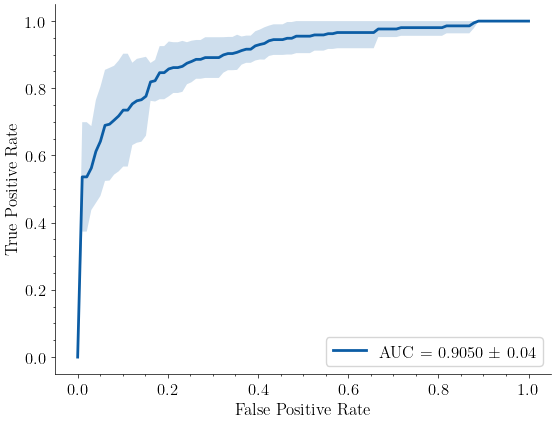

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

alpha= 0.2

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold in results.keys():

    fpr, tpr, _ = roc_curve(results[fold]['labels'], results[fold]['probs'])

    auc_aux = roc_auc_score(results[fold]['labels'], results[fold]['probs'])
    #plt.plot(fpr, tpr, lw=1,color='#d4d4d2')  # Plot ROC curve

    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc_aux)

   
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)


plt.plot(mean_fpr, mean_tpr, label=f'AUC = {mean_auc:.4f} ± {std_auc:.2f}')
plt.fill_between(mean_fpr, np.clip(mean_tpr-std_tpr,0,1),np.clip(mean_tpr+std_tpr,0,1), alpha=alpha, edgecolor='None')

#plt.title(f'ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#plt.savefig(os.path.join(path_experiments,f"roc_curve_{model}.png"), dpi=150, bbox_inches='tight')


c:\Users\leonardo\Desktop\Mestrado\utils\plots.py:312: RuntimeWarning: invalid value encountered in divide
  (all_bin_sums[0] / (all_bin_sums[0] + all_bin_sums[2])),
c:\Users\leonardo\Desktop\Mestrado\utils\plots.py:319: RuntimeWarning: invalid value encountered in divide
  (all_bin_sums[1] / (all_bin_sums[1] + all_bin_sums[3])),


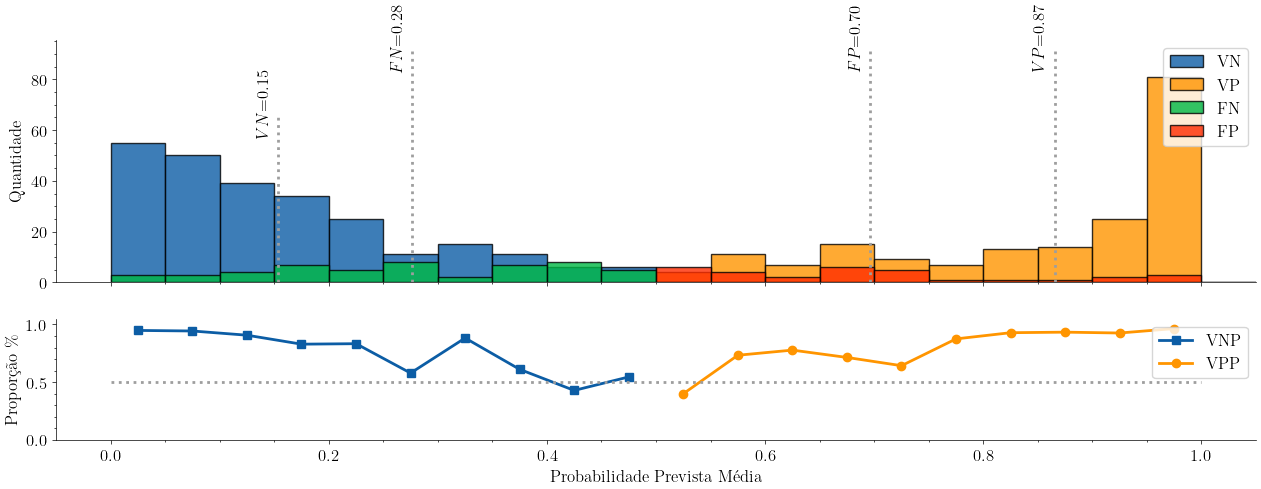

In [9]:
probs = []
labels = []
for fold in results.keys():
    probs.extend(results[fold]['probs'])
    labels.extend(results[fold]['labels'])

probability_histogram(np.array(probs), np.array(labels), path=path_experiments)

## Calibration Metrics Values

In [10]:
n_bins = 10
mode_metrics = 'quantile'
mode_plot = 'uniform'

In [11]:
# Validation metrics
ece = np.zeros(len(results.keys()))
mce = np.zeros(len(results.keys()))
nll = np.zeros(len(results.keys()))
brier = np.zeros(len(results.keys()))

# Cria arrays com os resultados
for i, fold in enumerate(results.keys()):
    metrics = calibration_metrics(results[fold]['probs'], results[fold]['labels'], n_bins=n_bins, mode=mode_metrics)
    ece[i] = metrics['ECE']
    mce[i] = metrics['MCE']
    nll[i] = metrics['NLL']
    brier[i] = metrics['Brier']

In [12]:
print(f"ECE    = {ece.mean():.4f} ± {ece.std():.2f}")
print(f"MCE    = {mce.mean():.4f} ± {mce.std():.2f}")
print(f"NLL    = {nll.mean():.4f} ± {nll.std():.2f}")
print(f"Brier  = {brier.mean():.4f} ± {brier.std():.2f}")


ECE    = 0.1214 ± 0.03
MCE    = 0.3618 ± 0.15
NLL    = 0.3755 ± 0.06
Brier  = 0.1167 ± 0.02


## Calibration Curve

In [13]:
def calib_pad_average_arrays(arrays):
    max_length = max(len(arr) for arr in arrays)

    avg = []
    std = []

    for i in range(max_length):
        values = []
        for arr in arrays:
            if i < len(arr):
                values.append(arr[i])
        
        values = np.array(values)
        avg.append(np.mean(values))
        std.append(np.std(values))

    return np.array(avg), np.array(std)

In [14]:
from calibration.metrics import ECE, calibration_curve


list_prob_true = []
list_prob_pred = []
list_probs = []
ece_list = []

for fold in results.keys():

    prob_true, prob_pred, _ =  calibration_curve(results[fold]['probs'], results[fold]['labels'], n_bins=n_bins, mode=mode_plot)

    ece_aux = ECE(results[fold]['probs'], results[fold]['labels'], n_bins=n_bins, mode=mode_metrics)

    list_prob_true.append(prob_true)
    list_prob_pred.append(prob_pred)
    list_probs.extend(results[fold]['probs'])
    ece_list.append(ece_aux)

average_prob_true, std_prob = calib_pad_average_arrays(list_prob_true)
average_prob_pred, std_pred = calib_pad_average_arrays(list_prob_pred)

list_probs = np.array(list_probs)
average_ece = np.array(ece_list).mean()
std_ece = np.array(ece_list).std()

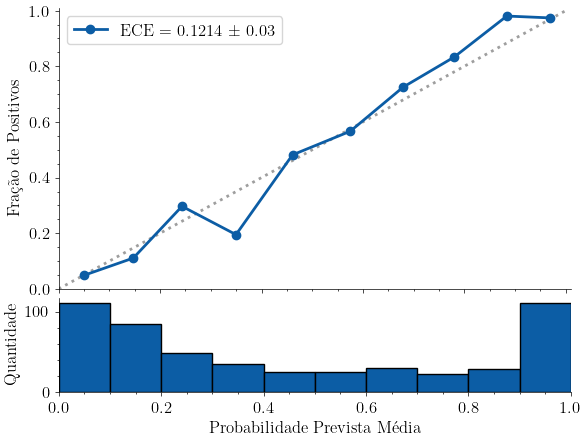

In [15]:
fig = plt.figure()

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05)

ax_curve = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])

#for prob_pred, prob_true in zip(list_prob_pred, list_prob_true):
    #ax_curve.plot(prob_pred, prob_true, color='#d4d4d2')


ax_curve.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle=":", color='#9e9e9e')

ax_curve.plot(average_prob_pred, average_prob_true, marker='o', label=f'ECE = {average_ece:.4f} ± {std_ece:.2f}')
#ax_curve.fill_between(average_prob_pred, np.clip(average_prob_true-std_prob,0,1),np.clip(average_prob_true+std_prob,0,1), alpha=0.3, edgecolor='None')

ax_hist.hist(list_probs, bins=np.linspace(0.0, 1.0, 10+1), edgecolor = 'black')

ax_curve.set_ylabel('Fração de Positivos')
ax_curve.legend(loc='upper left')
ax_curve.set_ylim([0,1.01])
ax_curve.set_xlim([0,1.01])
ax_curve.set_xticklabels([])

ax_hist.set_xlabel('Probabilidade Prevista Média')
ax_hist.set_ylabel('Quantidade')
ax_hist.set_xlim([0,1])
plt.savefig(os.path.join(path_experiments, f"calib_curve.pdf"), bbox_inches='tight')


In [16]:
s = ''
for x in [accuracy,f1,precision,sensitivity,specificity,auc,ece,mce,nll,brier]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,8197;0,8571;0,9138;0,7885;0,8431;0,8983;0,7778;0,8491;0,8333;0,8205
0,8197;0,8571;0,902;0,6452;0,7778;0,8966;0,7083;0,8621;0,8235;0,7586
0,8621;0,875;0,9583;0,8333;0,8235;0,8966;0,7391;0,8065;0,9333;0,8462
0,7812;0,84;0,8519;0,5263;0,7368;0,8966;0,68;0,9259;0,7368;0,6875
0,8621;0,875;0,9677;0,9394;0,9062;0,9;0,8421;0,7692;0,9412;0,913
0,9418;0,92;0,9188;0,8182;0,9046;0,9437;0,8821;0,8789;0,9257;0,9158
0,1766;0,1394;0,1245;0,1126;0,093;0,0619;0,0977;0,1348;0,165;0,1085
0,5981;0,3873;0,209;0,2695;0,3332;0,1497;0,2181;0,5679;0,5412;0,3438
0,3485;0,3629;0,3139;0,497;0,3601;0,2928;0,4003;0,4517;0,3774;0,3501
0,1096;0,116;0,0919;0,1596;0,1097;0,0875;0,1344;0,1309;0,1161;0,111

